# Problem 6: Bootstrapped DQN

In [1]:
import numpy as np
import random
from typing import Optional, List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import imageio

import gymnasium as gym
from gymnasium import spaces

from copy import deepcopy

In [2]:
# ======================================
# RiverSwim Environment (discrete states)
# ======================================
class RiverSwimEnv(gym.Env):
    """Classic RiverSwim (6 states by default).
    - States: 0 ... N-1 (start at 0). No terminal states.
    - Actions: 0=LEFT, 1=RIGHT.
    - Rewards: r_small at (s=0, LEFT), r_big at (s=N-1, RIGHT).
    - Episodes truncate at max_steps.
    """
    metadata = {"render_modes": ["rgb_array", "ansi"], "render_fps": 30}

    def __init__(self, n_states: int = 6, max_steps: int = 200,
                 r_small: float = 0.005, r_big: float = 1.0,
                 render_mode: Optional[str] = None):
        super().__init__()
        self.n_states = n_states
        self.max_steps = max_steps
        self.r_small = r_small
        self.r_big = r_big
        self.render_mode = render_mode

        self.observation_space = spaces.Discrete(self.n_states)
        self.action_space = spaces.Discrete(2)

        self.state = 0
        self.steps = 0

    def seed(self, seed: Optional[int] = None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

    def reset(self, *, seed: Optional[int] = None, options=None):
        if seed is not None:
            self.seed(seed)
        self.state = 0
        self.steps = 0
        info = {}
        return self.state, info

    def step(self, action: int):
        assert self.action_space.contains(action)
        s = self.state
        self.steps += 1

        # Reward depends on (state, action) BEFORE transition
        reward = 0.0
        if s == 0 and action == 0:
            reward = self.r_small
        if s == self.n_states - 1 and action == 1:
            reward = self.r_big

        # Transition
        u = random.random()
        if action == 0:  # LEFT
            if u < 0.6:
                s_next = max(0, s - 1)
            else:
                s_next = s
        else:  # RIGHT
            if u < 0.6:
                s_next = max(0, s - 1)
            elif u < 0.6 + 0.35:
                s_next = min(self.n_states - 1, s + 1)
            else:
                s_next = s

        self.state = s_next
        terminated = False
        truncated = self.steps >= self.max_steps
        info = {}

        if self.render_mode == "ansi":
            print(self._ansi())
        return self.state, reward, terminated, truncated, info

    def _ansi(self):
        cells = ["~"] * self.n_states
        cells[self.state] = "S"
        return "|" + "".join(cells) + "|"

    def render(self):
        if self.render_mode == "rgb_array":
            h, w = 40, 20 * self.n_states
            img = np.ones((h, w, 3), dtype=np.uint8) * 255
            # draw river cells
            for i in range(self.n_states):
                x0, x1 = i * 20, (i + 1) * 20
                img[5:35, x0 + 1 : x1 - 1, :] = np.array([200, 225, 255], dtype=np.uint8)
            # mark agent
            x0, x1 = self.state * 20, (self.state + 1) * 20
            img[10:30, x0 + 5 : x1 - 5, :] = np.array([255, 120, 120], dtype=np.uint8)
            return img
        return None

In [3]:
# --- RiverSwim config ---
n_states = 6
max_steps = 200
r_small = 0.005
r_big = 1.0

# --- Env ---
env = RiverSwimEnv(n_states=n_states, max_steps=max_steps,
                    r_small=r_small, r_big=r_big, render_mode="rgb_array")

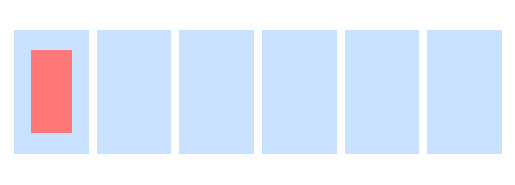

In [4]:
state, _ = env.reset()

frame = env.render()
plt.imshow(frame); plt.axis("off"); plt.show()

In [5]:
# ==============================
# Utilities
# ==============================

def one_hot(idx: int, size: int) -> np.ndarray:
    v = np.zeros((size,), dtype=np.float32)
    v[idx] = 1.0
    return v


def moving_average(arr, window=21):
    if window <= 1:
        return np.asarray(arr, dtype=float)
    arr = np.asarray(arr, dtype=float)
    cumsum = np.cumsum(np.insert(arr, 0, 0.0))
    ma_core = (cumsum[window:] - cumsum[:-window]) / window
    
    pad_left = window // 2
    pad_right = len(arr) - len(ma_core) - pad_left
    return np.pad(ma_core, (pad_left, pad_right), mode='edge')

### 1. DQN

In [6]:
# ==========================================================
# DQN (Deep Q-Network)
# ==========================================================
class QNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        activation: nn.Module = nn.ReLU,
    ) -> None:
        super(QNetwork, self).__init__()
        dims = [input_dim] + list(hidden_dims)
        layers = []
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(in_dim, out_dim), activation()]
        layers += [nn.Linear(dims[-1], output_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class DQNAgent:
    def __init__(
        self,
        q_network: nn.Module,
        optimizer: optim.Optimizer,
        input_dim: int,
        output_dim: int,
        epsilon_start: float,
        epsilon_final: float,
        epsilon_decay: float,
        target_update: int,
        batch_size: int,
        memory_capacity: int,
        gamma: float,
        tau: float
    ) -> None:
        self.q_network, self.target_network = q_network, deepcopy(q_network)
        self.target_network.eval()
        self.optimizer = optimizer

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay

        self.target_update = target_update
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.gamma = gamma
        self.tau = tau

        self.memory: List[Tuple[np.ndarray, int, float, np.ndarray, bool]] = []
        self.steps = 0

    def select_action(self, state_vec: np.ndarray):
        # state_vec is one-hot vector
        if random.random() < self.epsilon:
            return random.randint(0, self.output_dim - 1)
        else:
            state_t = torch.from_numpy(state_vec).float().unsqueeze(0)
            q_values = self.q_network(state_t)
            return int(q_values.argmax().item())

    def store_experience(self, state_vec, action, reward, next_state_vec, done):
        self.memory.append((state_vec, action, reward, next_state_vec, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Q(s,a)
        q_values = self.q_network(states)
        q_sa = q_values.gather(1, actions.view(-1, 1)).squeeze(1)

        # Target with target-network (vanilla DQN target; Double-DQN optional below)
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1).values
            y = rewards + self.gamma * (1.0 - dones) * next_q

        loss = nn.MSELoss()(q_sa, y)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 5.0)
        self.optimizer.step()

        # epsilon decay
        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

        # soft target update every target_update steps
        self.steps += 1
        if self.steps % self.target_update == 0:
            for t, q in zip(self.target_network.parameters(), self.q_network.parameters()):
                t.data.copy_(t.data * (1.0 - self.tau) + q.data * self.tau)

In [30]:
# ==========================================================
# Hyperparameters (tuned for RiverSwim)
# ==========================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- RiverSwim config ---
n_states = 6
max_steps = 200
r_small = 0.005
r_big = 1.0

epsilon_start = 1.0
epsilon_final = 0.05
epsilon_decay = 0.9995

target_update = 50
memory_capacity = 50_000
num_episodes = 500

lr = 3e-4
gamma = 0.995
tau = 0.05
batch_size = 256
hidden_dims = [64, 64]

In [31]:
# ==========================================================
# Init env/agent and Train
# ==========================================================
env = RiverSwimEnv(n_states=n_states, max_steps=max_steps, r_small=r_small, r_big=r_big, render_mode="rgb_array")
input_dim = env.n_states               # one-hot size
output_dim = env.action_space.n        # 2 actions

q_network = QNetwork(input_dim, output_dim, hidden_dims)
optimizer = optim.Adam(q_network.parameters(), lr=lr)

agent = DQNAgent(
    q_network=q_network,
    optimizer=optimizer,
    input_dim=input_dim,
    output_dim=output_dim,
    epsilon_start=epsilon_start,
    epsilon_final=epsilon_final,
    epsilon_decay=epsilon_decay,
    target_update=target_update,
    batch_size=batch_size,
    memory_capacity=memory_capacity,
    gamma=gamma,
    tau=tau,
)

DQN_record: List[float] = []
frames: List[np.ndarray] = []

for episode in range(num_episodes):
    state_idx, _ = env.reset()
    state_vec = one_hot(state_idx, env.n_states)
    done = False
    total_reward = 0.0

    while not done:
        action = agent.select_action(state_vec)
        next_state_idx, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state_vec = one_hot(next_state_idx, env.n_states)
        agent.store_experience(state_vec, action, reward, next_state_vec, done)
        agent.train()

        state_vec = next_state_vec
        total_reward += reward

        if episode == num_episodes - 1:
            frame = env.render()
            if frame is not None:
                frames.append(frame)

    DQN_record.append(total_reward)
    mean100 = float(np.mean(DQN_record[-20:]))
    print(f"Episode {episode + 1:4d} | Return: {total_reward:7.3f} | mean20: {mean100:7.3f} | eps: {agent.epsilon:6.3f}")

env.close()

Episode    1 | Return:   0.405 | mean20:   0.405 | eps:  1.000
Episode    2 | Return:   0.335 | mean20:   0.370 | eps:  0.930
Episode    3 | Return:   0.490 | mean20:   0.410 | eps:  0.842
Episode    4 | Return:   0.295 | mean20:   0.381 | eps:  0.761
Episode    5 | Return:   0.430 | mean20:   0.391 | eps:  0.689
Episode    6 | Return:   0.620 | mean20:   0.429 | eps:  0.623
Episode    7 | Return:   0.670 | mean20:   0.464 | eps:  0.564
Episode    8 | Return:   0.530 | mean20:   0.472 | eps:  0.510
Episode    9 | Return:   0.715 | mean20:   0.499 | eps:  0.462
Episode   10 | Return:   0.770 | mean20:   0.526 | eps:  0.418
Episode   11 | Return:   0.660 | mean20:   0.538 | eps:  0.378
Episode   12 | Return:   0.725 | mean20:   0.554 | eps:  0.342
Episode   13 | Return:   0.730 | mean20:   0.567 | eps:  0.310
Episode   14 | Return:   0.845 | mean20:   0.587 | eps:  0.280
Episode   15 | Return:   0.795 | mean20:   0.601 | eps:  0.253
Episode   16 | Return:   0.870 | mean20:   0.618 | eps:

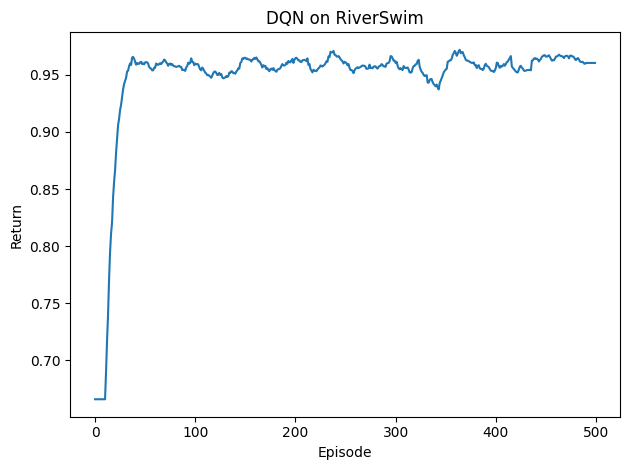

In [32]:
# Plot
plt.figure()
plt.plot(moving_average(DQN_record, window=20))
plt.title("DQN on RiverSwim")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

### 2. Bootstrapped DQN

In [11]:
# ======================================
# Bootstrapped DQN (multi-head network)
# ======================================
class BootstrappedQNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: List[int],
                 num_heads: int = 10, activation: nn.Module = nn.ReLU):
        super().__init__()
        self.output_dim = output_dim
        self.num_heads = num_heads

        dims = [input_dim] + list(hidden_dims)
        layers = []
        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(in_dim, out_dim), activation()]
        self.trunk = nn.Sequential(*layers)
        self.heads = nn.ModuleList([nn.Linear(dims[-1], output_dim) for _ in range(num_heads)])

    def q_values(self, x: torch.Tensor, head_idx: int) -> torch.Tensor:
        z = self.trunk(x)
        return self.heads[head_idx](z)

    @torch.no_grad()
    def act(self, x_np: np.ndarray, head_idx: int, epsilon: float) -> int:
        if random.random() < epsilon:
            return random.randrange(self.output_dim)
        x = torch.as_tensor(x_np, dtype=torch.float32).unsqueeze(0)
        q = self.q_values(x, head_idx)
        return int(q.argmax(dim=1).item())

In [12]:
class ReplayBuffer:
    def __init__(self, capacity: int, num_heads: int, bootstrap_p: float):
        self.capacity = capacity
        self.num_heads = num_heads
        self.bootstrap_p = bootstrap_p
        self.storage: List[Tuple[np.ndarray, int, float, np.ndarray, bool, np.ndarray]] = []
        self.pos = 0

    def __len__(self):
        return len(self.storage)

    def push(self, s, a, r, ns, d, acting_head):
        mask = (np.random.rand(self.num_heads) < self.bootstrap_p).astype(np.uint8)
        mask[acting_head] = 1  # ensure acting head learns from its own data
        transition = (s, a, r, ns, d, mask)
        if len(self.storage) < self.capacity:
            self.storage.append(transition)
        else:
            self.storage[self.pos] = transition
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int):
        batch = random.sample(self.storage, batch_size)
        s, a, r, ns, d, m = zip(*batch)
        s = torch.as_tensor(np.array(s), dtype=torch.float32)
        a = torch.as_tensor(np.array(a), dtype=torch.long)
        r = torch.as_tensor(np.array(r, dtype=np.float32))
        ns = torch.as_tensor(np.array(ns), dtype=torch.float32)
        d = torch.as_tensor(np.array(d, dtype=np.float32))
        m = torch.as_tensor(np.array(m, dtype=np.float32))
        return s, a, r, ns, d, m

In [13]:
class BootstrappedDQNAgent:
    def __init__(self,
        q_network: BootstrappedQNetwork,
        optimizer: optim.Optimizer,
        input_dim: int,
        output_dim: int,
        epsilon_start: float,
        epsilon_final: float,
        epsilon_decay: float,
        target_update: int,
        batch_size: int,
        memory_capacity: int,
        gamma: float,
        tau: float,
        num_heads: int = 10,
        bootstrap_p: float = 0.8,
    ):
        self.q = q_network
        self.tgt = deepcopy(q_network).eval()
        self.opt = optimizer

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.bootstrap_p = bootstrap_p

        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay

        self.target_update = target_update
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        self.replay = ReplayBuffer(memory_capacity, num_heads, bootstrap_p)
        self.steps = 0
        self.active_head = 0

    def begin_episode(self):
        self.active_head = random.randrange(self.num_heads)

    def select_action(self, onehot_state: np.ndarray) -> int:
        return self.q.act(onehot_state, self.active_head, self.epsilon)

    def store_experience(self, s, a, r, ns, d):
        self.replay.push(s, a, r, ns, d, self.active_head)

    def _soft_update(self):
        with torch.no_grad():
            for t, s in zip(self.tgt.parameters(), self.q.parameters()):
                t.data.mul_(1.0 - self.tau).add_(self.tau * s.data)

    def train(self):
        if len(self.replay) < self.batch_size:
            return None
        s, a, r, ns, d, m = self.replay.sample(self.batch_size)

        losses = []
        heads_used = 0
        for h in range(self.num_heads):
            sel = m[:, h] > 0.5
            if sel.sum() == 0:
                continue
            S = s[sel]
            A = a[sel]
            R = r[sel]
            NS = ns[sel]
            D = d[sel]

            q_sa = self.q.q_values(S, h).gather(1, A.view(-1, 1)).squeeze(1)
            with torch.no_grad():
                next_online = self.q.q_values(NS, h)
                next_a = next_online.argmax(dim=1, keepdim=True)
                next_target = self.tgt.q_values(NS, h)
                next_q = next_target.gather(1, next_a).squeeze(1)
                y = R + self.gamma * (1.0 - D) * next_q
            loss_h = nn.MSELoss()(q_sa, y)
            losses.append(loss_h)
            heads_used += 1

        if heads_used == 0:
            return None

        loss = torch.stack(losses).mean()
        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), 5.0)
        self.opt.step()

        # eps decay
        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

        self.steps += 1
        if self.steps % self.target_update == 0:
            self._soft_update()
        return float(loss.item())

In [ ]:
# =====================
# Training Entry Point
# =====================

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- RiverSwim config ---
n_states = 6
max_steps = 200
r_small = 0.005
r_big = 1.0

gamma = 0.995
lr = 3e-4
tau = 0.05
batch_size = 256
memory_capacity = 50_000

epsilon_start = 1.0
epsilon_final = 0.05
epsilon_decay = 0.9995
target_update = 50

hidden_dims = [64, 64]
num_heads = 10
bootstrap_p = 0.8

In [15]:
# --- Env ---
env = RiverSwimEnv(n_states=n_states, max_steps=max_steps,
                    r_small=r_small, r_big=r_big, render_mode="rgb_array")

input_dim = n_states              # one-hot state
output_dim = env.action_space.n   # 2 actions

qnet = BootstrappedQNetwork(input_dim, output_dim, hidden_dims, num_heads=num_heads)
optimizer = optim.Adam(qnet.parameters(), lr=lr)

agent = BootstrappedDQNAgent(
    q_network=qnet,
    optimizer=optimizer,
    input_dim=input_dim,
    output_dim=output_dim,
    epsilon_start=epsilon_start,
    epsilon_final=epsilon_final,
    epsilon_decay=epsilon_decay,
    target_update=target_update,
    batch_size=batch_size,
    memory_capacity=memory_capacity,
    gamma=gamma,
    tau=tau,
    num_heads=num_heads,
    bootstrap_p=bootstrap_p,
)

# --- Training loop ---
num_episodes = 500
bootstrapped_DQN_record: List[float] = []
frames = []

for ep in range(num_episodes):
    s_raw, _ = env.reset()
    s = one_hot(s_raw, n_states)
    agent.begin_episode()  # choose acting head for this episode
    done = False
    ret = 0.0

    while not done:
        a = agent.select_action(s)
        ns_raw, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        ns = one_hot(ns_raw, n_states)

        agent.store_experience(s, a, r, ns, done)
        agent.train()

        s = ns
        ret += r

        if ep == num_episodes - 1 and imageio is not None:
            frame = env.render()
            if frame is not None:
                frames.append(frame)

    bootstrapped_DQN_record.append(ret)
    mean20 = np.mean(bootstrapped_DQN_record[-20:])
    print(f"Ep {ep+1:4d} | head {agent.active_head:2d} | Return {ret:7.3f} | mean20 {mean20:7.3f} | eps {agent.epsilon:6.3f}")

Ep    1 | head  1 | Return   0.400 | mean20   0.400 | eps  1.000
Ep    2 | head  9 | Return   0.335 | mean20   0.368 | eps  0.930
Ep    3 | head  7 | Return   0.400 | mean20   0.378 | eps  0.842
Ep    4 | head  6 | Return   1.265 | mean20   0.600 | eps  0.761
Ep    5 | head  9 | Return   5.290 | mean20   1.538 | eps  0.689
Ep    6 | head  6 | Return   0.465 | mean20   1.359 | eps  0.623
Ep    7 | head  8 | Return   2.210 | mean20   1.481 | eps  0.564
Ep    8 | head  7 | Return   0.545 | mean20   1.364 | eps  0.510
Ep    9 | head  7 | Return   0.685 | mean20   1.288 | eps  0.462
Ep   10 | head  1 | Return   0.770 | mean20   1.236 | eps  0.418
Ep   11 | head  6 | Return   1.300 | mean20   1.242 | eps  0.378
Ep   12 | head  4 | Return   0.670 | mean20   1.195 | eps  0.342
Ep   13 | head  4 | Return   0.710 | mean20   1.157 | eps  0.310
Ep   14 | head  0 | Return   0.845 | mean20   1.135 | eps  0.280
Ep   15 | head  7 | Return   0.710 | mean20   1.107 | eps  0.253
Ep   16 | head  1 | Retur

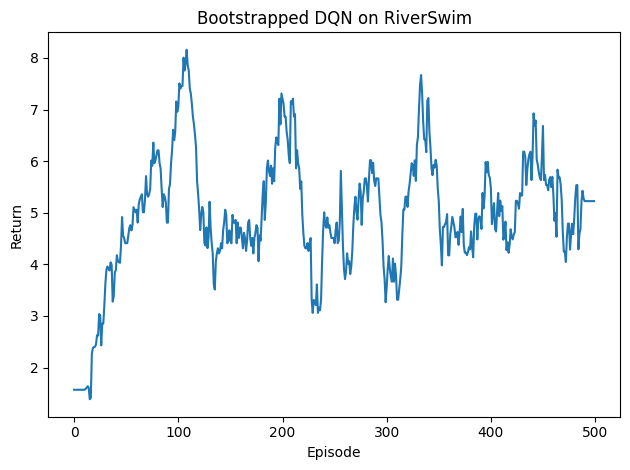

In [16]:
plt.figure()
plt.plot(moving_average(bootstrapped_DQN_record, window=20))
plt.title("Bootstrapped DQN on RiverSwim")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

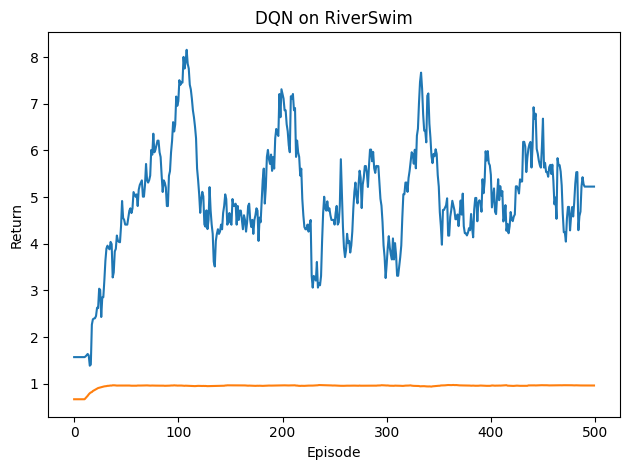

In [33]:
# Plot
plt.figure()
plt.plot(moving_average(bootstrapped_DQN_record, window=20))
plt.plot(moving_average(DQN_record, window=20))
plt.title("DQN on RiverSwim")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.tight_layout()
plt.show()